<a href="https://colab.research.google.com/github/arka57/Hindi-Vowel-Consonant-Classification/blob/main/HindiVowelConsonant_VGG16_CNN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torchvision.models as models
import torch.nn as nn
import copy

In [ ]:
#Creating the class

In [ ]:
#Code for converting dataset into torch tensor

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms

#For converting the dataset to torchvision dataset format
class VowelConsonantDataset(Dataset):
    def __init__(self, file_path,train=True,transform=None):
        self.transform = transform
        self.file_path=file_path
        self.train=train
        self.file_names=[file for _,_,files in os.walk(self.file_path) for file in files]
        self.len = len(self.file_names)
        if self.train:
            self.classes_mapping=self.get_classes()
    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, index):
        file_name=self.file_names[index]
        image_data=self.pil_loader(self.file_path+"/"+file_name)
        if self.transform:
            image_data = self.transform(image_data)
        if self.train:
            file_name_splitted=file_name.split("_")
            Y1 = self.classes_mapping[file_name_splitted[0]]
            Y2 = self.classes_mapping[file_name_splitted[1]]
            z1,z2=torch.zeros(10),torch.zeros(10)
            z1[Y1-10],z2[Y2]=1,1
            label=torch.stack([z1,z2])

            return image_data, label

        else:
            return image_data, file_name
          
    def pil_loader(self,path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

      
    def get_classes(self):
        classes=[]
        for name in self.file_names:
            name_splitted=name.split("_")
            classes.extend([name_splitted[0],name_splitted[1]])
        classes=list(set(classes))
        classes_mapping={}
        for i,cl in enumerate(sorted(classes)):
            classes_mapping[cl]=i
        return classes_mapping

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets

import torchvision.transforms as transforms

import numpy as np
import pandas as pd

train_on_gpu = torch.cuda.is_available()

In [ ]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
cd MyDrive/DL/project/Hindi_Vowel_Consonant

/gdrive/MyDrive/DL/project/Hindi_Vowel_Consonant


In [ ]:
full_data = VowelConsonantDataset("./train",train=True,transform=transform)
train_size = int(0.9 * len(full_data))
test_size = len(full_data) - train_size

train_data, validation_data = random_split(full_data, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=32, shuffle=True)

In [ ]:
test_data = VowelConsonantDataset("./test",train=False,transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32,shuffle=False)

In [ ]:
resnet=models.resnet50(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
#modified_classifier=list(vgg16.classifier.children())[:-3]
#print(modified_classifier)

In [ ]:
#model VGG16 with fully connected layer modified

In [ ]:
class VC_vgg16(nn.Module):
    def __init__(self):
        super(VC_vgg16,self).__init__()
        self.model_vgg16=models.vgg16_bn(pretrained=True)#inheriting the existing model
        modified_classifier=list(self.model_vgg16.classifier.children())[:-3] #modifying the last layers
        self.model_vgg16.classifier=nn.Sequential(*modified_classifier) #adding the changed layers in the model

        self.v_model=nn.Sequential( #fully connected layer for vowel
            nn.Linear(4096,2048),
            nn.ReLU(),
            nn.Linear(2048,512),
            nn.ReLU(),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Linear(128,10)

        )
        self.c_model=nn.Sequential( #fully connected layer for consonant
            nn.Linear(4096,2048),
            nn.ReLU(),
            nn.Linear(2048,512),
            nn.ReLU(),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Linear(128,10)
        )

    def forward(self,x):
        x=self.model_vgg16(x)
        v=self.v_model(x)
        c=self.c_model(x)
        return v,c
        

In [ ]:
print(VC_vgg16())

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VC_vgg16(
  (model_vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=

In [ ]:
#Instantiating network

In [ ]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import torch.optim as optim

net=VC_vgg16().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(), lr = 0.005)

In [ ]:
print(net)

VC_vgg16(
  (model_vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=

In [ ]:
#parameters

In [ ]:
torch.Size([1024, 4096]),torch.Size([1024]),torch.Size([10])


In [ ]:
#making exisiting part of VGG16 to not be trained once again as it is already pre-trained

In [ ]:
for p in net.parameters():
    if p.shape not in (torch.Size([1024, 4096]),torch.Size([1024]),torch.Size([10]),torch.Size([10, 1024])):
        p.requires_grad=False
        

In [ ]:
for p in net.parameters():
    if p.requires_grad:
        print(p.shape)

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512,

In [ ]:
for i,p in enumerate(net.parameters()):
    if p.requires_grad:
        print(i,p.shape)

0 torch.Size([64, 3, 3, 3])
1 torch.Size([64])
2 torch.Size([64])
3 torch.Size([64])
4 torch.Size([64, 64, 3, 3])
5 torch.Size([64])
6 torch.Size([64])
7 torch.Size([64])
8 torch.Size([128, 64, 3, 3])
9 torch.Size([128])
10 torch.Size([128])
11 torch.Size([128])
12 torch.Size([128, 128, 3, 3])
13 torch.Size([128])
14 torch.Size([128])
15 torch.Size([128])
16 torch.Size([256, 128, 3, 3])
17 torch.Size([256])
18 torch.Size([256])
19 torch.Size([256])
20 torch.Size([256, 256, 3, 3])
21 torch.Size([256])
22 torch.Size([256])
23 torch.Size([256])
24 torch.Size([256, 256, 3, 3])
25 torch.Size([256])
26 torch.Size([256])
27 torch.Size([256])
28 torch.Size([512, 256, 3, 3])
29 torch.Size([512])
30 torch.Size([512])
31 torch.Size([512])
32 torch.Size([512, 512, 3, 3])
33 torch.Size([512])
34 torch.Size([512])
35 torch.Size([512])
36 torch.Size([512, 512, 3, 3])
37 torch.Size([512])
38 torch.Size([512])
39 torch.Size([512])
40 torch.Size([512, 512, 3, 3])
41 torch.Size([512])
42 torch.Size([512]

In [ ]:
for i,p in enumerate(net.parameters()):
    if i<56:
        p.requires_grad=False

In [ ]:
for i,p in enumerate(net.parameters()):
    if p.requires_grad:
        print(i,p.shape)

56 torch.Size([2048, 4096])
57 torch.Size([2048])
58 torch.Size([512, 2048])
59 torch.Size([512])
60 torch.Size([128, 512])
61 torch.Size([128])
62 torch.Size([10, 128])
63 torch.Size([10])
64 torch.Size([2048, 4096])
65 torch.Size([2048])
66 torch.Size([512, 2048])
67 torch.Size([512])
68 torch.Size([128, 512])
69 torch.Size([128])
70 torch.Size([10, 128])
71 torch.Size([10])


In [ ]:
def evaluation(dataloader):
    total=0
    correct=0
    for i in dataloader:
        images,labels=i
        #print("images shape:",images.shape)
        #print("labels shape",labels.shape)
        images,labels=images.to(device),labels.to(device)
        

        vowel_label,consonant_label=labels[:,0,:],labels[:,1,:]
        _,vowel_label=torch.max(vowel_label,1)
        _,consonant_label=torch.max(consonant_label,1)
        #print("vowel_label shape",vowel_label.shape)
        #print("consonant_label shape",consonant_label.shape)    
        vowel,consonant=net(images)
        #print("vowel shape",vowel.shape)
        #print("consonant shape",consonant.shape) 
        _,vowel_pred=torch.max(vowel,1)
        _,consonant_pred=torch.max(consonant,1)
        #print("vowel_pred shape",vowel_pred.shape)
        #print("consonant_pred shape",consonant_pred.shape) 
        total+=labels.size(0)
        correct_v=(vowel_pred==vowel_label)
        correct_c=(consonant_pred==consonant_label)
        correct+=(correct_v+correct_c).sum().item()
    return (correct/total)*100

In [ ]:
torch.cuda.empty_cache()

In [ ]:
evaluation(train_loader)

In [ ]:
import copy

Loss 4.62
Loss 4.44
Loss 4.20
Epoch 0/16, Training Accuaracy 31.51, Test Accuracy 31.50
Loss 4.15
Loss 4.35
Loss 4.37
Epoch 1/16, Training Accuaracy 35.60, Test Accuracy 35.60
Loss 4.03
Loss 4.11
Loss 4.53
Epoch 2/16, Training Accuaracy 37.01, Test Accuracy 36.50
Loss 4.34
Loss 4.16
Loss 4.04
Epoch 3/16, Training Accuaracy 37.89, Test Accuracy 38.00
Loss 4.16
Loss 4.08
Loss 4.02
Epoch 4/16, Training Accuaracy 36.62, Test Accuracy 33.30
Loss 3.97
Loss 3.92
Loss 4.15
Epoch 5/16, Training Accuaracy 37.78, Test Accuracy 34.20
Loss 4.11
Loss 3.89
Loss 3.84
Epoch 6/16, Training Accuaracy 38.16, Test Accuracy 35.90
Loss 3.93
Loss 3.90
Loss 4.05
Epoch 7/16, Training Accuaracy 37.41, Test Accuracy 35.50
Loss 4.33
Loss 3.93
Loss 4.05
Epoch 8/16, Training Accuaracy 39.39, Test Accuracy 35.30
Loss 4.23
Loss 3.84
Loss 4.17
Epoch 9/16, Training Accuaracy 38.63, Test Accuracy 35.60
Loss 3.95
Loss 4.09
Loss 4.07
Epoch 10/16, Training Accuaracy 39.98, Test Accuracy 37.40
Loss 3.82
Loss 3.83
Loss 4.11
E

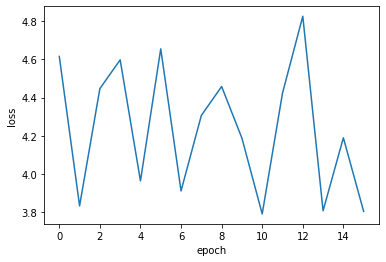

CPU times: user 38min 25s, sys: 1min 20s, total: 39min 45s
Wall time: 1h 28min 37s


In [ ]:
%%time
loss_epoch=[]
epochs=16
min_loss=1000

for i in range(epochs):
    for j,data in enumerate(train_loader,0):
        input,labels=data
        input,labels=input.to(device),labels.to(device)
        #print(input.shape)            #(32,3,224,224)
        #print(labels.shape)           #(32,2,10)
        
        
        vowel_label,consonant_label=labels[:,0,:],labels[:,1,:]
        
        vowel,consonant=net.forward(input)
        #print(vowel_label.shape)      #(32,10)
        #print(consonant_label.shape)  #(32,10)
        #print(vowel.shape)            #(32,10)
        #print(consonant.shape)        #(32,10)
        lossV=loss_fn(vowel,vowel_label)
        lossC=loss_fn(consonant,consonant_label)
        loss=lossV+lossC
        loss.backward()

        opt.step()
        opt.zero_grad()

        if min_loss> loss :
            min_loss=loss
            best_model = copy.deepcopy(net.state_dict())

        if(j%100==0):
            print('Loss %0.2f'%loss.item())
        del vowel,consonant,labels,input
        torch.cuda.empty_cache()
        
    loss_epoch.append(loss.item())
    print('Epoch %d/%d, Training Accuaracy %0.2f, Test Accuracy %0.2f' % (i,epochs,evaluation(train_loader),evaluation(validation_loader))) 

net.load_state_dict(best_model)
plt.plot(loss_epoch)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()